Find Changepoints
==========

I want to see the effect of a station closing or opening on the other stations in the system, most likely those stations either linked to it on the same line or those that are physically closer to each other.

In [45]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pymc3 as pm

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

In [80]:
user = 'mikemoran'
database = 'fullstations'

engine = create_engine(f'postgres://{user}@localhost/{database}')
conn = psycopg2.connect(database=database, user=user)

In [119]:
details = pd.read_sql('select * from details;', conn)
details.head()

,unit,station,linename,c_a
0,R001,SOUTH FERRY,1R,R101
1,R001,SOUTH FERRY,1RW,R101
2,R001,WHITEHALL S-FRY,R1,A058
3,R001,WHITEHALL S-FRY,R1,A060
4,R001,WHITEHALL S-FRY,R1W,A058


In [96]:
ues_units = ['R051', 'R144', 'R177', 'R178', 'R179',
             'R180', 'R181', 'R182', 'R132', 'R319',
             'R570', 'R571', 'R572']

In [125]:
def build_large_query(units, start, stop):
    select = '{}.enter {}_enter'
    join = 'full outer join {} on {}.date_time = {}.date_time'
    select_parts = ',\n'.join(select.format(u, u) for u in units)
    start_station = units.pop(0)
    join_parts = '\n'.join(join.format(u, start_station, u) for u in units)
    query = f'''
        select {start_station}.date_time, {select_parts}
        from {start_station} {join_parts}
        where {start_station}.date_time between '{start}' and '{stop}'
        order by date_time asc;
    '''
    return query

query = build_large_query(ues_units, '2016-10-01', '2017-02-28')
print(query)


        select R144.date_time, R144.enter R144_enter,
R177.enter R177_enter,
R178.enter R178_enter,
R179.enter R179_enter,
R180.enter R180_enter,
R181.enter R181_enter,
R182.enter R182_enter,
R132.enter R132_enter,
R319.enter R319_enter,
R570.enter R570_enter,
R571.enter R571_enter,
R572.enter R572_enter
        from R144 full outer join R177 on R144.date_time = R177.date_time
full outer join R178 on R144.date_time = R178.date_time
full outer join R179 on R144.date_time = R179.date_time
full outer join R180 on R144.date_time = R180.date_time
full outer join R181 on R144.date_time = R181.date_time
full outer join R182 on R144.date_time = R182.date_time
full outer join R132 on R144.date_time = R132.date_time
full outer join R319 on R144.date_time = R319.date_time
full outer join R570 on R144.date_time = R570.date_time
full outer join R571 on R144.date_time = R571.date_time
full outer join R572 on R144.date_time = R572.date_time
        where R144.date_time between '2016-10-01' and '2017

In [105]:
def pull_data(query, conn):
    df = (pd.read_sql(query, conn, parse_dates=['date_time'])
            .set_index('date_time'))
    try:
        df.index = df.index.tz_convert('EST')
    except TypeError:
        df.index = df.index.tz_localize('EST')
    df['date'] = df.index.date
    summed_df = df.groupby('date')[df.columns].sum()
    return summed_df


df = pull_data(query, conn)
df.head()

,r051_enter,r144_enter,r177_enter,r178_enter,r179_enter,r180_enter,r181_enter,r182_enter,r132_enter,r319_enter,r570_enter,r571_enter,r572_enter
date,,,,,,,,,,,,,
2016-10-01,17510.0,9526.0,10197.0,13726.0,28194.0,7593.0,6903.0,9525.0,15869.0,6951.0,NaN,NaN,NaN
2016-10-02,23130.0,10541.0,11143.0,16006.0,36733.0,7684.0,7642.0,10927.0,18162.0,9093.0,NaN,NaN,NaN
2016-10-03,24322.0,18282.0,19380.0,25012.0,46012.0,11682.0,10148.0,13737.0,26025.0,9990.0,NaN,NaN,NaN
2016-10-04,36875.0,23516.0,28152.0,32510.0,59711.0,14123.0,11310.0,14926.0,29360.0,14888.0,NaN,NaN,NaN
2016-10-05,39940.0,27959.0,34316.0,36979.0,66406.0,16564.0,13364.0,17637.0,32302.0,16897.0,NaN,NaN,NaN


In [110]:
df.index = pd.to_datetime(df.index)

Now, try to automatically detect the changepoint (Jan 1 2017) within the data...

In [30]:
def plot_verify(trace, data):
    lambda_1_samples = trace['lambda_1']
    lambda_2_samples = trace['lambda_2']
    tau_samples = trace['tau']
    
    N = tau_samples.shape[0]
    expected_per_day = np.zeros(data.shape[0])
    for day in range(0, data.shape[0]):
        ix = day < tau_samples
        expected_per_day[day] = (lambda_1_samples[ix].sum()
                                       + lambda_2_samples[~ix].sum()) / N
    plt.plot(range(data.shape[0]), expected_per_day, lw=4, color="#E24A33",
             label="expected number of passengers")
    plt.xlabel("Day")
    plt.ylabel("Expected passengers")
    plt.title("Expected number of passengers")
    plt.bar(np.arange(data.shape[0]), data.values, color="#348ABD", alpha=0.65,
            label="observed passengers per day", width=1.0)
    plt.legend(loc="lower left")
    plt.show()

In [111]:
df.index.get_loc('2017-01-01')
# window = slice('2016-10-01', '2017-03-31')

92

In [113]:
def get_stations_associated_with_lines(conn):
    query = '''
        select unit, station, linename from details;
    '''
    details = pd.read_sql(query, conn)
    units = details.unit.unique().tolist()
    stations = [details.station[details.unit == u].iloc[-1] for u in units]
    lines = [details.linename[details.unit == u].tolist() for u in units]
    lines = [''.join(sorted(list(set(''.join(l))))) for l in lines]
    details = list(zip(units, stations, lines))
    df = pd.DataFrame(data=details, columns=['unit', 'station', 'line'])
    df['color'] = df.line.str[0]
    df.color = df.color.apply(lambda x: colors[x])
#     details.sort(key=lambda x: x[1])
#     details_dict = {u: (s, l) for u, s, l in zip(units, stations, lines)}
#     return details, details_dict
    return df

colors = {'A': 'rgb(0, 57, 166)', 'C': 'rgb(0, 57, 166)',
          'E': 'rgb(0, 57, 166)',
          'B': 'rgb(255,99,25)', 'D': 'rgb(255,99,25)', 'F': 'rgb(255,99,25)',
          'M': 'rgb(255,99,25)', 'G': 'rgb(108,190,69)',
          'J': 'rgb(153,102,51)', 'Z': 'rgb(153,102,51)',
          'L': 'rgb(167,169,172)',
          'N': 'rgb(252,204,10)', 'Q': 'rgb(252,204,10)',
          'R': 'rgb(252,204,10)', 'S': 'rgb(128,129,131)',
          '1': 'rgb(238,53,46)', '2': 'rgb(238,53,46)', '3': 'rgb(238,53,46)',
          '4': 'rgb(0,147,60)', '5': 'rgb(0,147,60)', '6': 'rgb(0,147,60)',
          '7': 'rgb(185,51,173)'}

df = get_stations_associated_with_lines(conn)
df.head()

,unit,station,line,color
0,R001,WHITEHALL ST,1RW,"rgb(238,53,46)"
1,R003,CYPRESS HILLS,J,"rgb(153,102,51)"
2,R004,ELDERTS LANE,JZ,"rgb(153,102,51)"
3,R005,FOREST PARKWAY,J,"rgb(153,102,51)"
4,R006,WOODHAVEN BLVD,JZ,"rgb(153,102,51)"


In [117]:
df.set_index('unit').to_csv('line_station_color_details.csv')

In [126]:
units = sorted(details.unit.unique().tolist())
units[:5]
# units

['R001', 'R003', 'R004', 'R005', 'R006']

In [133]:
query = build_large_query(ues_units, '2016-01-01', '2018-01-01')
df = pull_data(query, conn)
df.head()

,r178_enter,r179_enter,r180_enter,r181_enter,r182_enter,r132_enter,r319_enter,r570_enter,r571_enter,r572_enter
date,,,,,,,,,,
2016-01-01,10286.0,21794.0,5904.0,4921.0,7122.0,10465.0,4750.0,NaN,NaN,NaN
2016-01-02,8437.0,42958.0,6589.0,5325.0,7620.0,14748.0,6430.0,NaN,NaN,NaN
2016-01-03,5529.0,43589.0,5522.0,4464.0,6792.0,14666.0,6954.0,NaN,NaN,NaN
2016-01-04,22161.0,60673.0,11344.0,11670.0,13575.0,23505.0,13188.0,NaN,NaN,NaN
2016-01-05,36186.0,63764.0,14857.0,12317.0,16040.0,28123.0,15252.0,NaN,NaN,NaN


In [158]:
df.columns = [n.split('_')[0].upper() for n in df.columns]
test = df.head()
test
# df.fillna(0).to_csv('ridership_since_dec.csv')

,R178,R179,R180,R181,R182,R132,R319,R570,R571,R572
date,,,,,,,,,,
2016-01-01,10286.0,21794.0,5904.0,4921.0,7122.0,10465.0,4750.0,NaN,NaN,NaN
2016-01-02,8437.0,42958.0,6589.0,5325.0,7620.0,14748.0,6430.0,NaN,NaN,NaN
2016-01-03,5529.0,43589.0,5522.0,4464.0,6792.0,14666.0,6954.0,NaN,NaN,NaN
2016-01-04,22161.0,60673.0,11344.0,11670.0,13575.0,23505.0,13188.0,NaN,NaN,NaN
2016-01-05,36186.0,63764.0,14857.0,12317.0,16040.0,28123.0,15252.0,NaN,NaN,NaN


In [147]:
df.index = pd.to_datetime(df.index)
df.index

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2017-06-01', '2017-06-02', '2017-06-03', '2017-06-04',
               '2017-06-05', '2017-06-06', '2017-06-07', '2017-06-08',
               '2017-06-09', '2017-06-10'],
              dtype='datetime64[ns]', name='date', length=527, freq=None)

In [157]:
df.loc[:'2017-04-30'], df.loc['2017-04-30':]

(               R178     R179     R180     R181     R182     R132     R319  \
 date                                                                        
 2016-01-01  10286.0  21794.0   5904.0   4921.0   7122.0  10465.0   4750.0   
 2016-01-02   8437.0  42958.0   6589.0   5325.0   7620.0  14748.0   6430.0   
 2016-01-03   5529.0  43589.0   5522.0   4464.0   6792.0  14666.0   6954.0   
 2016-01-04  22161.0  60673.0  11344.0  11670.0  13575.0  23505.0  13188.0   
 2016-01-05  36186.0  63764.0  14857.0  12317.0  16040.0  28123.0  15252.0   
 2016-01-06  36948.0  65590.0  16034.0  13006.0  16487.0  29515.0  15082.0   
 2016-01-07  37728.0  65873.0  15886.0  13055.0  18555.0  29757.0  15523.0   
 2016-01-08  33642.0  70624.0  16012.0  12251.0  14726.0  30989.0  16613.0   
 2016-01-09  24448.0  43656.0  12048.0   8084.0  12168.0  22119.0  10019.0   
 2016-01-10  15743.0  33475.0   6995.0   5969.0   9423.0  13712.0   6863.0   
 2016-01-11  27020.0  60370.0  12308.0  12375.0  14403.0  23895.

In [129]:
df.fillna(0).to_csv('ridership_since_dec.csv')

In [6]:
def get_model_results(data, sample=1000, tune=500):
    with pm.Model() as model:
        mu = data.mean()
        lambda_1 = pm.Poisson('lambda_1', mu)
        lambda_2 = pm.Poisson('lambda_2', mu)

        tau = pm.DiscreteUniform('tau', lower=0, upper=data.shape[0])
        idx = np.arange(data.shape[0])  # Index
        lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)
        observation = pm.Poisson('obs', lambda_, observed=data.values)
        step = pm.Metropolis()
        trace = pm.sample(sample, tune=tune, step=step)
    return trace

In [148]:
expected_tau = df.index.get_loc('2017-01-01')
# expected_tau
window = slice(expected_tau - 60, expected_tau + 60)

def prediction(window):
    saved_traces = []
    for station in ues_units:
        data = df[station].fillna(0)
        data = data.iloc[window]
        trace = get_model_results(data, sample=10000, tune=5000)
        saved_traces.append(trace)
    return saved_traces

results = prediction(window)

100%|██████████| 10000/10000 [00:02<00:00, 3733.16it/s]


In [14]:
# trace_df = (pd.DataFrame({'station':ins, 'l1':saved_l1, 'l2':saved_l2})
#             .set_index('station'))
# #             .transpose())
# trace_df['p_diff'] = trace_df.diff(axis=1)['l2']
# trace_df['elas'] = trace_df.p_diff / trace_df.l1
# trace_df

Elasticity
------------

After speaking with Jesse, I can find the joint elasticity between stations, or (in my case) the joint elasticity between the 456 stations and the new Q extension. Since those stations opened as a whole, I can't really separate out their effects from each other.

Elasticity is the change in quantity sold of an item for a given change in price of that item. In my case, the quantity sold is ridership (number of riders entering a given station), and the price of that item is a "human" price (weather, walking distance, preference, etc.) that I cannot define for everyone. The shock events of opening a station changes the supply of subway rides available, and the new station has a cost associated with it for each person. For those people where the cost of the new station(s) is less than the other stations, they will switch stations, and the riders serviced by each will respond based on the elasticity for those stations when looked at on the whole.

Our model is still the `pymc3` one, where the hyperparameter we're tuning is the window around the shock event to use.

In [149]:
pre_saved = []
post_saved = []

for name, trace in zip(ues_units, results):
    pre = trace['lambda_1'][5000:].mean(), trace['lambda_1'][5000:].std()
    post = trace['lambda_2'][5000:].mean(), trace['lambda_2'][5000:].std()
    change = trace['tau'][5000:].mean()
    print('{}: {:.0f}+/-{:.0f} --> {:.0f}+/-{:.0f} ({:.1f})'.format(name, *pre, *post, change))
    pre_saved.append(pre[0])
    post_saved.append(post[0])

R179: 56259+/-32 --> 39776+/-25 (58.0)
R180: 13569+/-14 --> 12362+/-15 (65.0)
R181: 11043+/-12 --> 10549+/-14 (65.0)
R182: 14741+/-15 --> 14156+/-17 (65.0)
R132: 26601+/-22 --> 23925+/-19 (51.0)
R319: 13919+/-15 --> 16437+/-17 (61.0)
R570: 1+/-0 --> 22071+/-19 (59.0)
R571: 1+/-0 --> 19293+/-17 (59.0)
R572: 1+/-0 --> 12589+/-14 (59.0)


In [151]:
delta_pct = [(post - pre) / pre for pre, post in zip(pre_saved, post_saved)]
delta = pd.Series([post - pre for pre, post in zip(pre_saved, post_saved)], index=ues_units, name='delta')
delta_pct

[-0.29299150120029338,
 -0.088939542300688165,
 -0.044699252813483865,
 -0.039692671820098037,
 -0.10058284077704162,
 0.18090041208800084,
 22070.195199999998,
 19291.648799999999,
 12587.8596]

In [152]:
delta

R179   -16483.5546
R180    -1206.7884
R181     -493.6162
R182     -585.1256
R132    -2675.5994
R319     2517.9384
R570    22070.1952
R571    19291.6488
R572    12587.8596
Name: delta, dtype: float64

In [166]:
ratio_mat = np.array([[a / b for a in delta] for b in delta])
# mask = np.identity(ratio_mat.shape[0])
# ratio_mat -= mask
test_df = pd.DataFrame(data=np.NaN, index=units, columns=units)
test_df['R570'] = delta / delta.loc['R570']
test_df.loc['R570'] = delta.loc['R570'] / delta
test_df['R571'] = delta / delta.loc['R571']
test_df.loc['R571'] = delta.loc['R571'] / delta
test_df['R572'] = delta / delta.loc['R572']
test_df.loc['R572'] = delta.loc['R572'] / delta
test_df

,R003,R004,R005,R006,R007,R008,R009,R010,R011,R012,...,R546,R547,R548,R549,R550,R551,R552,R570,R571,R572
R003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
R004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
R005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
R006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
R007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
R008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
R009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
R010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
R011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
R012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [165]:
test_pre = 10000 * np.ones(len(ins))
e_values = test_df['R571']  # let's say we adjust the ridership at this station
delta_s86 = -2000
delta_others = 1 / (e_values / delta_s86)
delta_others

R179     2340.714642
R180    31971.883058
R181    78164.569153
R182    65940.197455
R132    14420.431399
R319   -15323.368356
R570    -1748.208262
R571    -2000.000000
R572    -3065.119792
Name: R571, dtype: float64

In [130]:
ues_units

['R177',
 'R178',
 'R179',
 'R180',
 'R181',
 'R182',
 'R132',
 'R319',
 'R570',
 'R571',
 'R572']

In [167]:
engine = create_engine(f'postgres://{user}@{host}/fullstations')

test_df.to_sql('ratio', engine, if_exists='replace')
test_df.to_csv('switchyard/static/data/ratio.csv')

l_in


/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


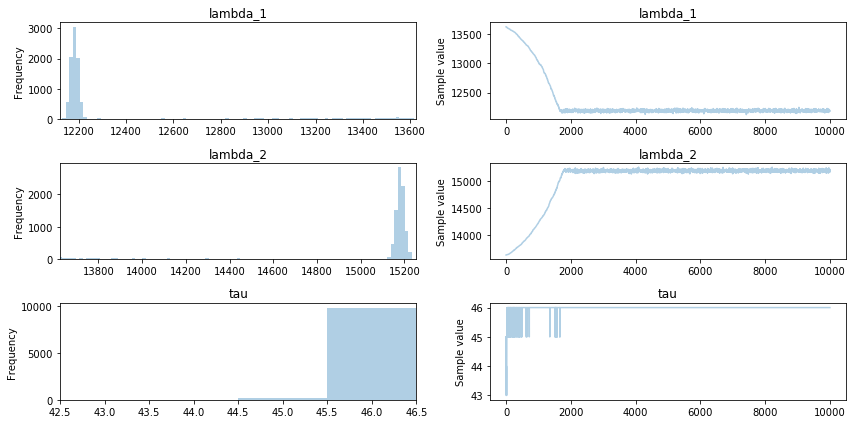

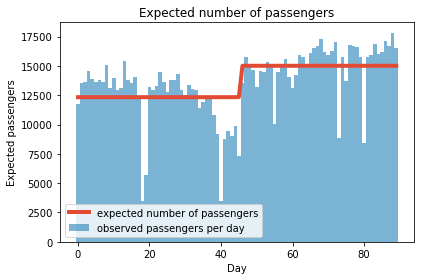

s72_in


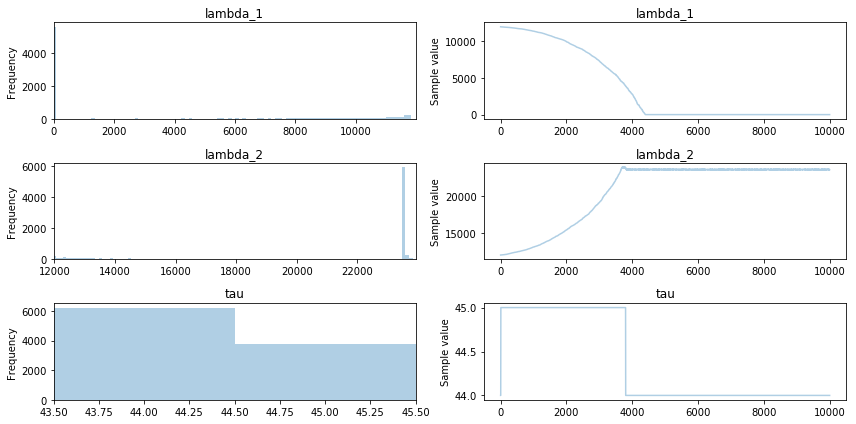

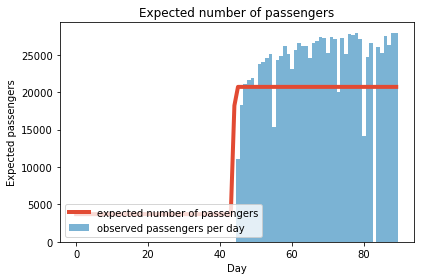

s86_in


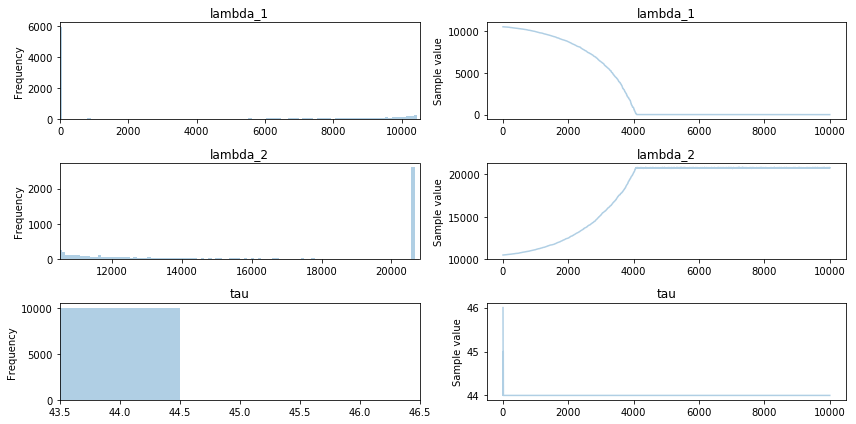

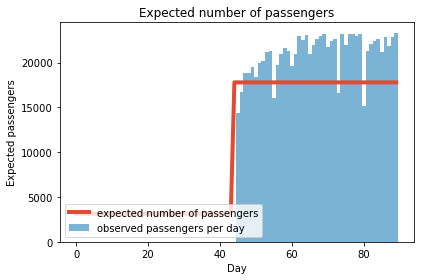

s96_in


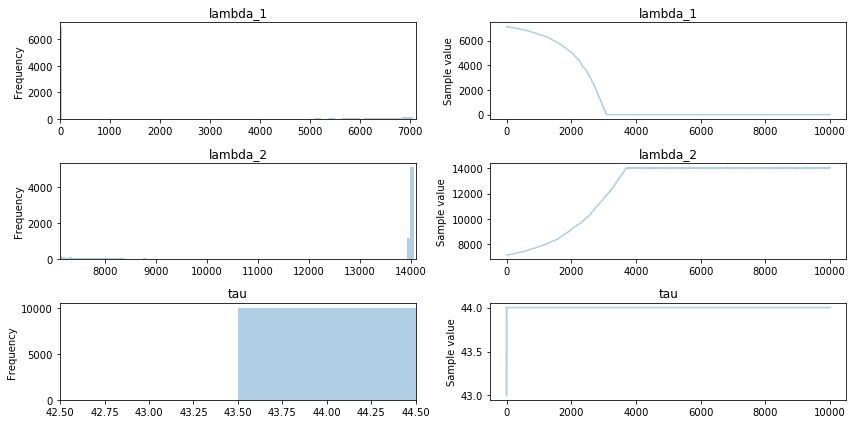

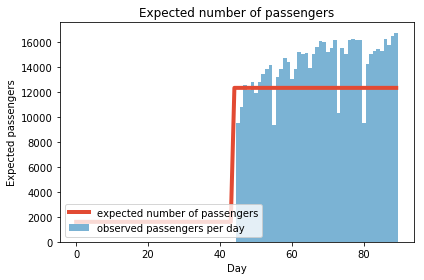

g68_in


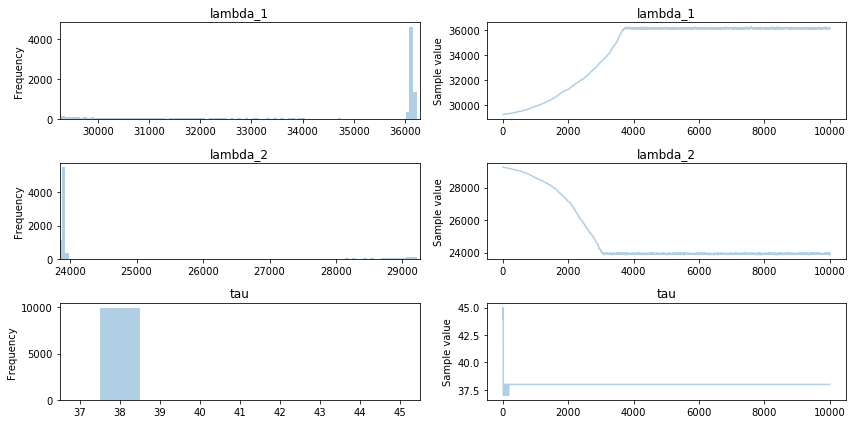

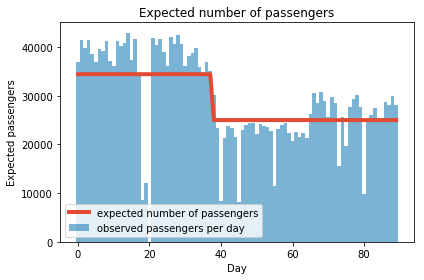

g77_in


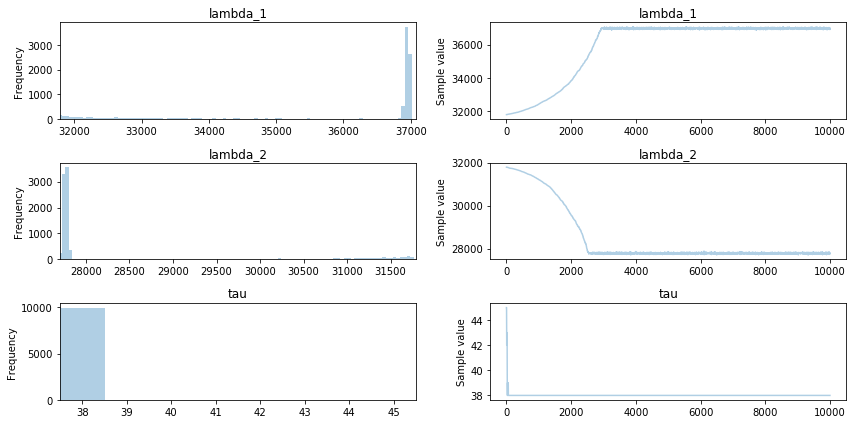

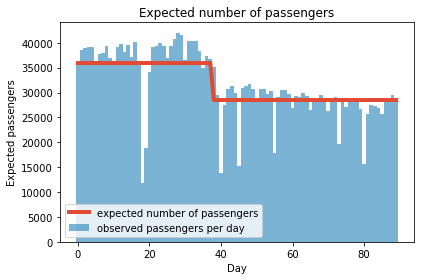

g86_in


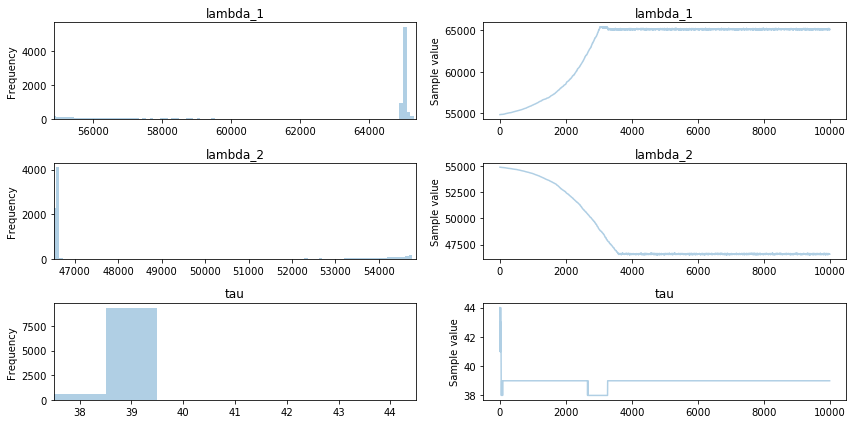

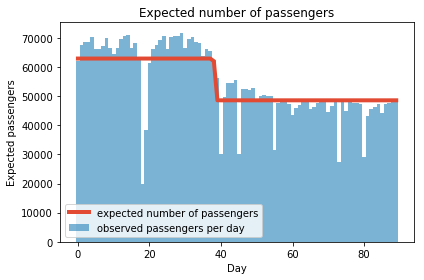

g96_in


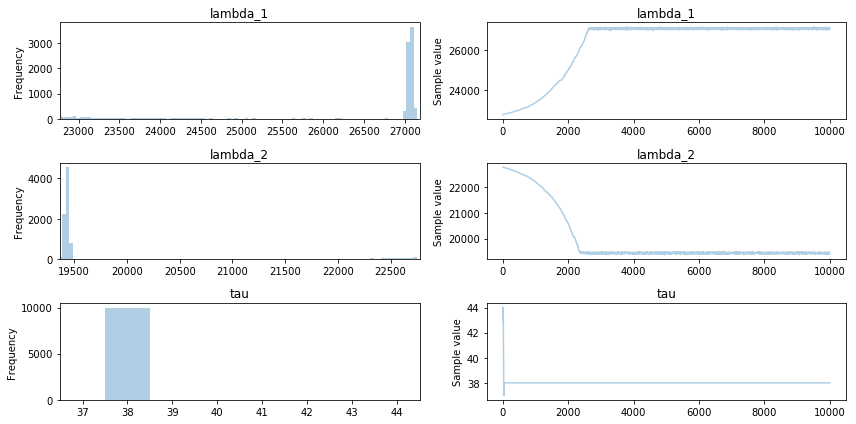

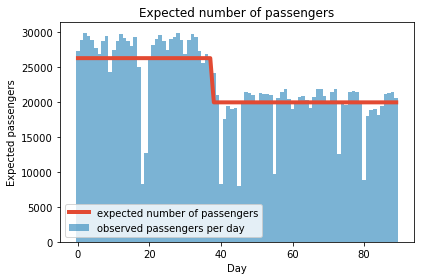

g103_in


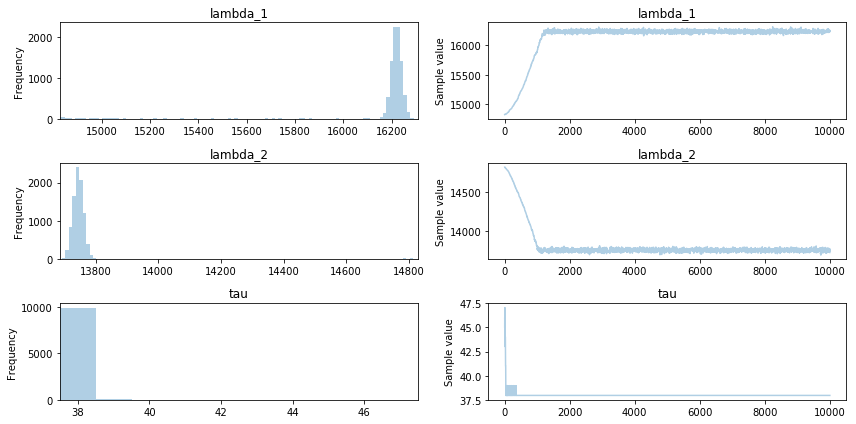

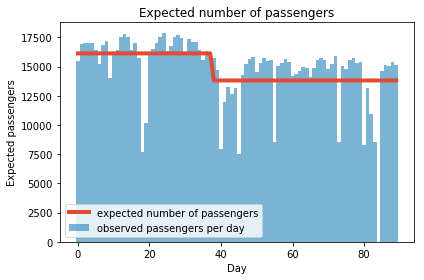

g110_in


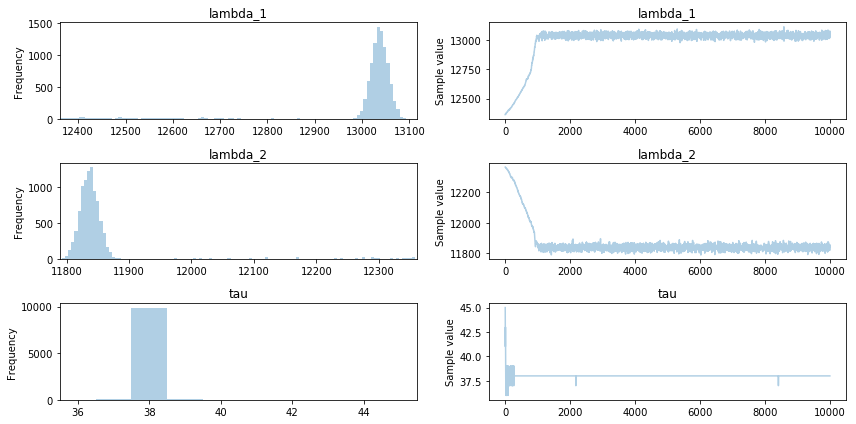

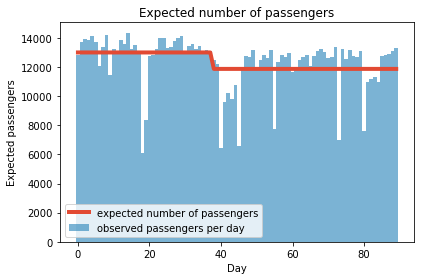

g116_in


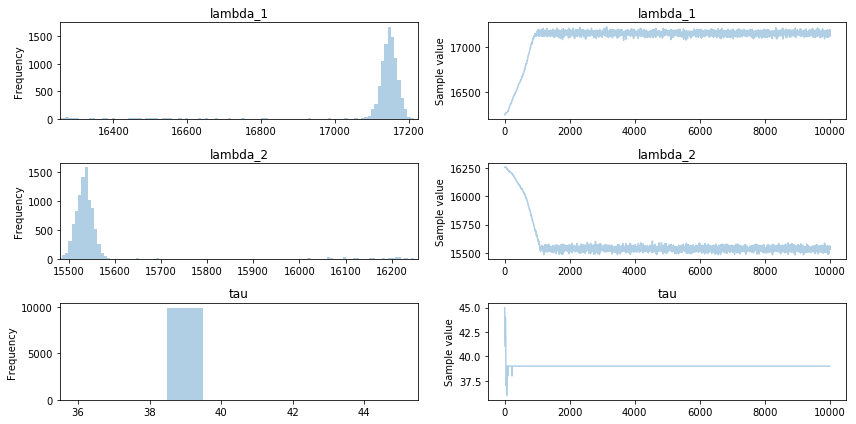

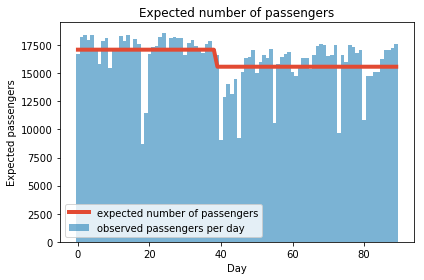

g125_in


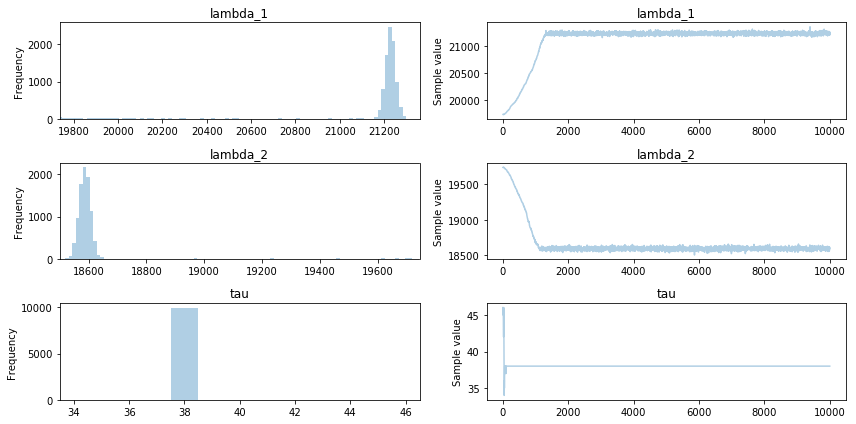

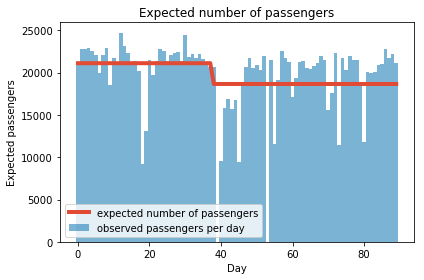

In [31]:
for trace, name in zip(results, ins):
    print(name)
    _ = pm.traceplot(trace)
    plt.show()
    plot_verify(trace, df_weekdays.iloc[window][name])

In [34]:
test_trace = results[-1]
test_trace['lambda_1'][5000:].mean()

21237.389599999999

Elasticity Matrix
--------------------

We want the elasticity between the stations. For that, we need to compare the change in ridership at the stations before the "shock" to after the shock. So the percent change in ridership of station 1 over the percent change in ridership of station 2 would be the elasticity bewteen those stations.

In [27]:
df_ins.columns

Index(['l_in', 's72_in', 's86_in', 's96_in', 'g68_in', 'g77_in', 'g86_in',
       'g96_in', 'g103_in', 'g110_in', 'g116_in', 'g125_in'],
      dtype='object')

In [207]:
test_701a = (pd.read_sql('select * from "N701A";', conn)
               .drop(['level_0', 'index', 'division', 'desc', 'entries', 'exits'], axis=1)
               .set_index('date_time', drop=True))
test_701 = (pd.read_sql('select * from "N701";', conn)
               .drop(['level_0', 'index', 'division', 'desc', 'entries', 'exits'], axis=1)
               .set_index('date_time', drop=True))
test_701.head()

,c_a,unit,scp,station,linename,dentries,dexits
date_time,,,,,,,
2016-12-31 00:00:00,N701,R571,00-00-00,86 ST-2 AVE,Q,NaN,NaN
2016-12-31 04:00:00,N701,R571,00-00-00,86 ST-2 AVE,Q,0.0,0.0
2016-12-31 08:00:00,N701,R571,00-00-00,86 ST-2 AVE,Q,0.0,0.0
2016-12-31 12:00:00,N701,R571,00-00-00,86 ST-2 AVE,Q,0.0,0.0
2016-12-31 16:00:00,N701,R571,00-00-00,86 ST-2 AVE,Q,1.0,4.0


/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


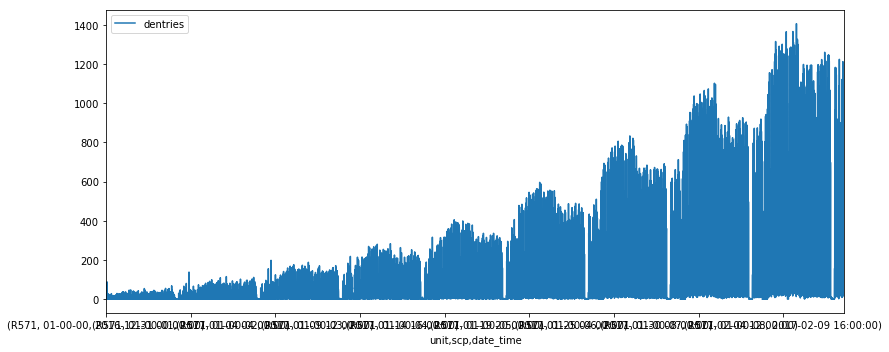

In [213]:
summed_701a = test_701a.groupby(['unit', 'scp', 'date_time']).sum()
summed_701a.dentries = np.abs(summed_701a.dentries)
summed_701a[summed_701a.dentries > 30000] = np.NaN
summed_701a.plot.line(y='dentries')

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


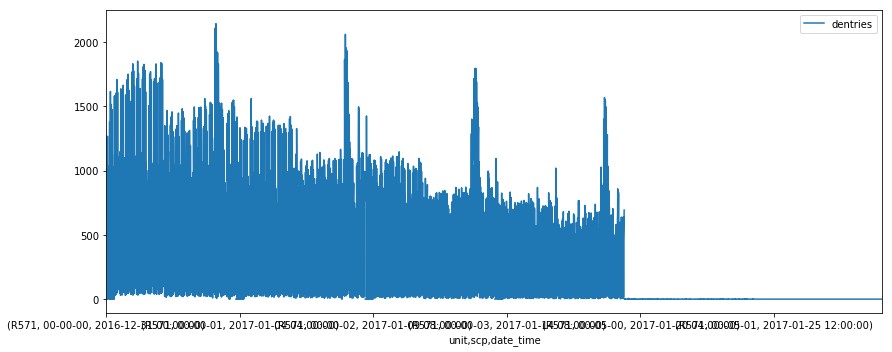

In [211]:
summed_701 = test_701.groupby(['unit', 'scp', 'date_time']).sum()
summed_701.dentries = np.abs(summed_701.dentries)
summed_701[summed_701.dentries > 30000] = np.NaN
summed_701.plot.line(y='dentries')